<center>
<img src="../img/ml_theme.png">
# Майнор "Интеллектуальный анализ данных" 
# Курс "Введение в программирование"
<img src="../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Семинар 14. ООП
## Дополнительная часть. Метод ближайших соседей

## Суть метода

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотезой компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных. 

Согласно методу ближайших соседей, тестовый пример (зеленый шарик) будет отнесен к классу "синие", а не "красные".

<img src="../img/kNN.png">

Например, если не знаешь, какой тип товара указать в объявлении для Bluetooth-гарнитуры, можешь найти 5 похожих гарнитур, и если 4 из них отнесены к категории "Аксессуары", и только один - к категории "Техника", то здравый смысл подскажет для своего объявления тоже указать категорию "Аксессуары".

Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
 - Вычислить расстояние до каждого из объектов обучающей выборки
 - Отобрать k объектов обучающей выборки, расстояние до которых минимально
 - Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди k ближайших соседей

Примечательное свойство таково подхода  - его ленивость. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при  наличии обучающих примеров, никакая модель не стоится. В этом отличие, например, от ранее рассмотренного дерева решений, где сначала на основе обучающей выборки строится дерево, а потом относительно быстро происходит классификация тестовых примеров. 

Качество классификации методом ближайших соседей зависит от нескольких параметров:
 - число соседей
 - метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо нормализовать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100. 
 - веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

## Класс KNeighborsClassifier в Scikit-learn

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
 - weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
 - algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем - расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автматически на основе обучающей выборки.
 - leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для нахождения соседей
 - metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

## Пример

Рассмотрим пример на применение метода ближайших соседей из библиотеки Scikit-learn для набора данных о параметрах цветков ириса (ирисы Фишера, один из самых известных в машинном обучении наборов данных). В этом наборе 150 экземплярах ириса, по 50 экземпляров из трёх видов — ирис щетинистый (Iris setosa), ирис виргинский (Iris virginica) и ирис разноцветный (Iris versicolor). Для каждого экземпляра указаны четыре характеристики (в сантиметрах): длина наружной доли околоцветника (sepal length), ширина наружной доли околоцветника (sepal width), длина внутренней доли околоцветника (petal length) и ширина внутренней доли околоцветника (petal width).

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
import pandas as pd
import numpy as np
import pylab as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn import preprocessing

Populating the interactive namespace from numpy and matplotlib


In [2]:
iris = datasets.load_iris()
X = iris.data[:, :2] 
y = iris.target

Для классификации будут использоваться 15 соседей тестового объекта. Далее задаются параметры визуализации - шаг сетки (по сути, разрешение картинки) и цветовые схемы. 

In [3]:
n_neighbors = 15
h = .02  
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

Обучаем классификатор для двух типов взвешивания соседей - либо все с равными весами (параметр weights='uniform'), либо веса обратно пропорциональны расстоянию до тестового примера (параметр weights='distance').

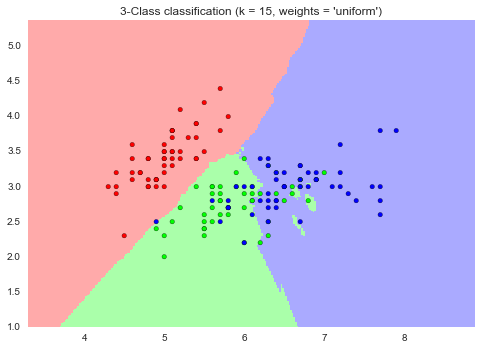

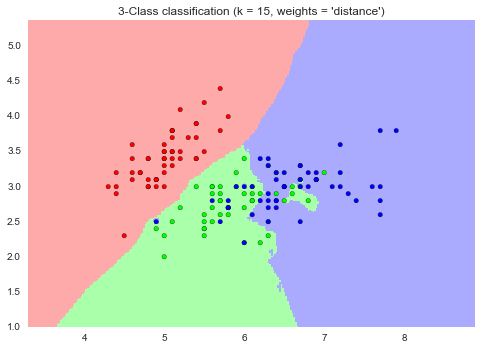

In [4]:
for weights in ['uniform', 'distance']:
    # создаем экземпляр классифкатора и передаем ему обучающую выборку
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)

    # Строим разделяющию кривую Plot the decision boundary. Для каждой точки
    # из [x_min, m_max]x[y_min, y_max] указываем цвет в соответствии с предсказанным классом 
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Отображаем также обучающие примеры
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()

# Плюсы и минусы подхода

В этом разделе мы познакомились с самым простым и интуитивно понятным методом классификации, деревом решений, и посмотрели, как он используется в библиотеке Scikit-learn в задаче классификации. 
Пока мы не обсуждали, как оценивать качество классификации и как бороться с переобучением деревьев решений. 
Отметим плюсы и минусы данного подхода.

Плюсы:
 - Легко расширять обучающую выборку
 - Хорошая интерпретация, можно объяснить, почему тестовый пример был классифицирован именно так
 
Минусы:
 - Большая вычислительная сложность
 - Если в наборе данных много переменных, то трудно подобрать подходящие веса и определить, какие переменные несущественны
 - Зависимость от выбранной метрики расстояния между примерами. Выбор по умолчанию евклидового расстояния чаще всего ничем не обоснован
 - Нет теоретических оснований выбора определенного числа соседей - только перебор. В случае малого числа соседей метод чувствителен к выбросам 
 - Можно отыскать хорошее решение перебором параметров, но для большого набора данных это отнимает много времени

**Пример**

Посмотрим kNN в действии на данных по автострахованию. <a href="https://inclass.kaggle.com/c/beeline-car-insurance-2015">Соревнование.</a>

Считаем, помимо прочих признаков, номер региона по номеру автомобиля.

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

In [6]:
def load_train_and_test(path_to_train, path_to_test):
    # read data into pandas data frames
    train_df = pd.read_csv(path_to_train,
                           header=0, index_col=0)
    test_df = pd.read_csv(path_to_test,
                          header=0, index_col=0)

    def extract_region(auto_number):
        """
        Returns region based on the auto number
        X796TH96RUS -> 96
        E432XX77RUS -> 77
        If there are more than 2-3 digits before 'RUS', 
        returns "not-auto-num"
        """
        index = auto_number.rindex("RUS") - 1
        while auto_number[index].isdigit():
            index -= 1
        auto_number = auto_number[index + 1 :auto_number.rindex('RUS')]
        return auto_number if len(auto_number) <= 3 else "not-auto-num"

    # auto brand and too_much are categorical so we encode these columns
    # ex: "Volvo" -> 1, "Audi" -> 2 etc
    auto_brand_encoder = preprocessing.LabelEncoder()
    auto_brand_encoder.fit(train_df['auto_brand'])
    target_encoder = preprocessing.LabelEncoder()
    target_encoder.fit(train_df['too_much'])
    region_encoder = preprocessing.LabelEncoder()
    regions_train = train_df['auto_number'].apply(extract_region)
    region_encoder.fit(regions_train)

    train_df['region'] = region_encoder\
                        .transform(regions_train)
    train_df['auto_brand'] = auto_brand_encoder\
                            .transform(train_df['auto_brand'])

    # form a numpy array to fit as train set labels
    y = train_df['too_much']

    train_df = train_df.drop(['auto_number', 'too_much'], axis=1)

    test_df['region'] = region_encoder\
                        .transform(test_df['auto_number']\
                                   .apply(extract_region))
    test_df['auto_brand'] = auto_brand_encoder\
                            .transform(test_df['auto_brand'])
    test_df = test_df.drop('auto_number', axis=1)
    return train_df, y, test_df

In [7]:
X_train, y, X_test = load_train_and_test("../data/car_insurance_train.csv",
                                         "../data/car_insurance_test.csv")

In [8]:
knn_params = {'n_neighbors': list(range(3, 12, 2))}

# make an instance of grid searcher
best_clf = GridSearchCV(KNeighborsClassifier(), 
                        knn_params, 
                        verbose=True)

# fit X and y (train set and corresponding labels) to the classifier
best_clf.fit(X_train, y)

print("Best params:", best_clf.best_params_)
print("Best cross validaton score", best_clf.best_score_)

# make predictions. This results in 0.74 AUC score
predicted_labels = best_clf.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'n_neighbors': 11}
Best cross validaton score 0.678090575275


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.0s finished


**У такой посылки результат - 0.74 AUC на публичной выборке**

<img src="../img/knn_cv-test_acc_car_insurance.png">